In [1]:
%%capture
!pip install pandas nltk scikit-learn

In [2]:
import numpy as np
import pandas as pd
import nltk
from preprocessing import lowercase_data, remove_punctuation, remove_stopwords, LemmatizerOrStemmer, WordSimplification
from typing import Tuple, Dict, List, Union, Set
from evaltools import evaluate

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
dtypes = {
    'ArticleId': 'int32',
    'Text': 'str',
    'Category': 'category'
}
data_train = pd.read_csv('data/BBC News Train.csv', dtype=dtypes, encoding='utf-8', index_col='ArticleId')
data_test = pd.read_csv('data/BBC News Test.csv', dtype={'ArticleId': 'int32', 'Text': 'str'}, encoding='utf-8', index_col='ArticleId')
data_test_solution = pd.read_csv('data/BBC News Sample Solution.csv', dtype={'ArticleId': 'int32', 'Category': 'category'}, encoding='utf-8', index_col='ArticleId')
data_test['Category'] = data_test_solution['Category']
data = pd.concat([data_train, data_test])
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business
1582,howard truanted to play snooker conservative...,politics
651,wales silent on grand slam talk rhys williams ...,sport
1797,french honour for director parker british film...,entertainment
2034,car giant hit by mercedes slump a slump in pro...,business


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 1833 to 471
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      2225 non-null   object  
 1   Category  2225 non-null   category
dtypes: category(1), object(1)
memory usage: 28.5+ KB


In [5]:
data.Category.value_counts()

Category
sport            493
business         483
politics         421
entertainment    420
tech             408
Name: count, dtype: int64

## Preprocessing

In [6]:
def data_preprocessing(data: Union[pd.Series, List[str], str], stopwords: Set[str]) -> Union[pd.Series, List[str], str]:
    data = lowercase_data(data)
    data = remove_punctuation(data)
    data = remove_stopwords(data, stopwords)
    return data

In [7]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))

data['Text'] = data_preprocessing(data['Text'], english_stopwords)
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens maj...,business
1976,lifestyle governs mobile choice faster better ...,tech
917,enron bosses payout eighteen former enron dire...,business
1582,howard truanted play snooker conservative lead...,politics
651,wales silent grand slam talk rhys williams say...,sport
1797,french honour director parker british film dir...,entertainment
2034,car giant hit mercedes slump slump profitabili...,business


In [8]:
word_simplifier_type = WordSimplification.LEMMATIZER
word_simplifier = LemmatizerOrStemmer(WordSimplification.LEMMATIZER)

data['Text'] = word_simplifier.simplify(data['Text'])
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens maj...,business
1976,lifestyle governs mobile choice faster better ...,tech
917,enron bosses payout eighteen former enron dire...,business
1582,howard truanted play snooker conservative lead...,politics
651,wales silent grand slam talk rhys williams say...,sport
1797,french honour director parker british film dir...,entertainment
2034,car giant hit mercedes slump slump profitabili...,business


In [9]:
user_interests: Dict[int, List[str]] = {
    1: ['politics'],
    2: ['entertainment'],
    3: ['sport'],
    4: ['tech'],
    5: ['business']
}

In [10]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def preprocess_user_interests(user_interests: Dict[int, List[str]]) -> Dict[int, List[str]]:
    interests_processed = {}
    for user_id, interests in user_interests.items():
         interests_processed[user_id] = data_preprocessing(interests, english_stopwords)
    return interests_processed

num_documents_to_retrieve = 5  # Number of documents to retrieve for each user
user_interests = preprocess_user_interests(user_interests)
user_interests

{1: ['politics'],
 2: ['entertainment'],
 3: ['sport'],
 4: ['tech'],
 5: ['business']}

# TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

def get_tfidf(data: pd.Series, *, min_df: float = None, max_df: float = None, stop_words_language: str = 'english', max_features: int = 1000) -> Tuple[TfidfVectorizer, csr_matrix]:
    data = data.fillna('')
    vectorizer = TfidfVectorizer(min_df=min_df or 0.0, max_df=max_df or 1.0,  stop_words=stop_words_language, max_features=max_features)
    vectors = vectorizer.fit_transform(data)
    return vectorizer, vectors

In [12]:
vectorizer, document_vectors = get_tfidf(data['Text'], max_df=0.15, stop_words_language='english', max_features=1000)

In [13]:
document_vectors.shape

(2225, 1000)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

user_retrieved_documents: Dict[int, pd.DataFrame] = {
    user_id: pd.DataFrame(
        index=data.index,
        columns=['SimilarityScore']
    )
    for user_id, _ in user_interests.items()
}

for user_id, interests in user_interests.items():
    print(f'User {user_id} have interests: [{", ".join(interests)}]')
    interests_simplified = word_simplifier.simplify(interests)
    for interest in interests_simplified:
        query_vector = vectorizer.transform([interest])
        similarity_scores = cosine_similarity(query_vector, document_vectors)[0]
        top_documents_indices = similarity_scores.argsort()[::-1]
        for document_index in top_documents_indices:
            article_id = data.index[document_index]
            user_retrieved_documents[user_id].loc[article_id] = similarity_scores[document_index]
            print(f'\tDocument {article_id} with similarity score {similarity_scores[document_index]:.2f}')

User 1 have interests: [politics]
	Document 642 with similarity score 0.57
	Document 1792 with similarity score 0.49
	Document 553 with similarity score 0.32
	Document 2211 with similarity score 0.27
	Document 825 with similarity score 0.27
	Document 86 with similarity score 0.25
	Document 14 with similarity score 0.25
	Document 1104 with similarity score 0.24
	Document 882 with similarity score 0.20
	Document 2055 with similarity score 0.18
	Document 613 with similarity score 0.16
	Document 1858 with similarity score 0.15
	Document 1721 with similarity score 0.15
	Document 1142 with similarity score 0.14
	Document 592 with similarity score 0.14
	Document 609 with similarity score 0.13
	Document 2204 with similarity score 0.13
	Document 934 with similarity score 0.13
	Document 1899 with similarity score 0.11
	Document 169 with similarity score 0.11
	Document 322 with similarity score 0.11
	Document 2106 with similarity score 0.10
	Document 208 with similarity score 0.10
	Document 1856 

In [15]:
user_retrieved_documents[2].sort_values(by='SimilarityScore', ascending=False).head(num_documents_to_retrieve)

,SimilarityScore
ArticleId,
985,0.501943
326,0.284209
1090,0.262389
1147,0.248024
184,0.22768


Precision and Recall at k for k=1,...,5
	Query 1
		P(1)=0/1=0.00,	R(1)=0/2=0.00
		P(2)=1/2=0.50,	R(2)=1/2=0.50
		P(3)=1/3=0.33,	R(3)=1/2=0.50
		P(4)=1/4=0.25,	R(4)=1/2=0.50
		P(5)=2/5=0.40,	R(5)=2/2=1.00
	Query 2
		P(1)=1/1=1.00,	R(1)=1/2=0.50
		P(2)=1/2=0.50,	R(2)=1/2=0.50
		P(3)=2/3=0.67,	R(3)=2/2=1.00
		P(4)=2/4=0.50,	R(4)=2/2=1.00
		P(5)=2/5=0.40,	R(5)=2/2=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/1=0.00
		P(2)=0/2=0.00,	R(2)=0/1=0.00
		P(3)=0/3=0.00,	R(3)=0/1=0.00
		P(4)=1/4=0.25,	R(4)=1/1=1.00
		P(5)=1/5=0.20,	R(5)=1/1=1.00
	Query 4
		P(1)=0/1=0.00,	R(1)=0/1=0.00
		P(2)=0/2=0.00,	R(2)=0/1=0.00
		P(3)=0/3=0.00,	R(3)=0/1=0.00
		P(4)=0/4=0.00,	R(4)=0/1=0.00
		P(5)=1/5=0.20,	R(5)=1/1=1.00
	Query 5
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=2/3=0.67,	R(3)=2/4=0.50
		P(4)=3/4=0.75,	R(4)=3/4=0.75
		P(5)=4/5=0.80,	R(5)=4/4=1.00

 Draw the Precision-Recall curve for each query
	Query 1


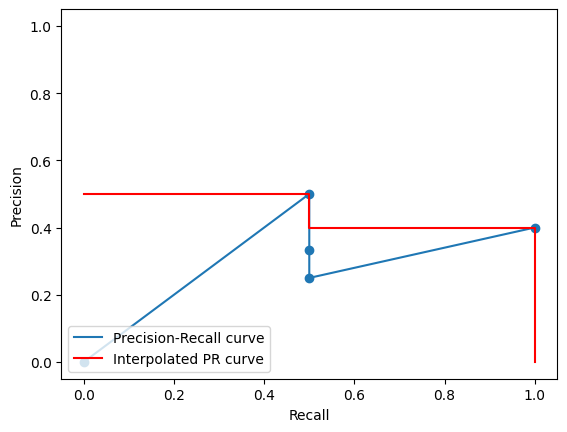

	Query 2


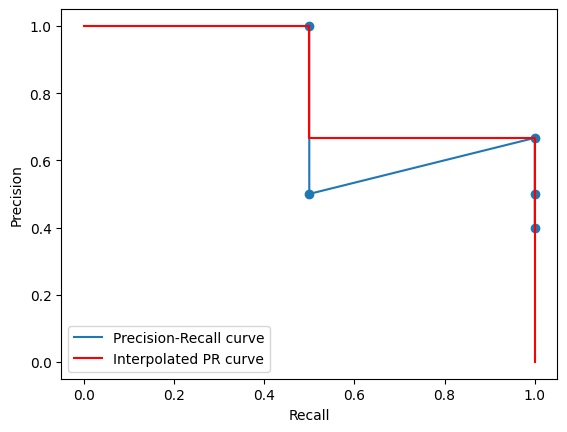

	Query 3


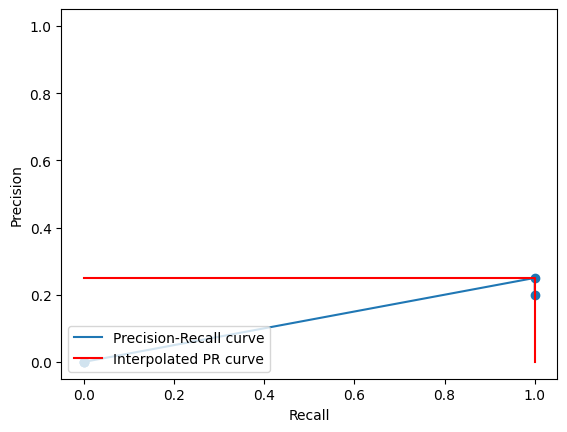

	Query 4


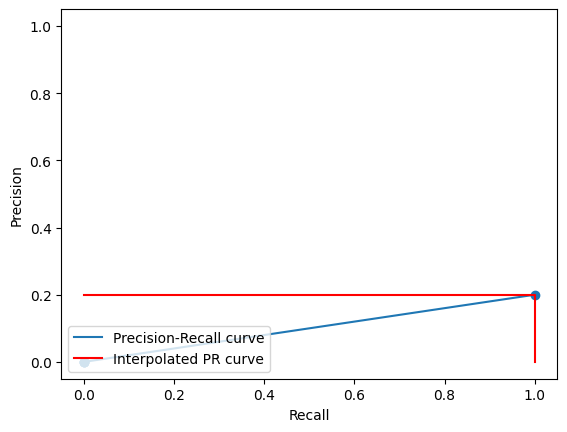

	Query 5


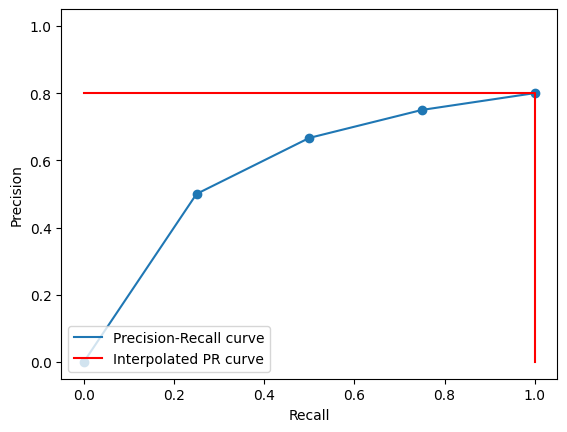

In [16]:
Q = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    Q.append(np.array(retrieved_documents.index))
    
R = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    R.append(np.array([1 if data.loc[article_id, 'Category'] in user_interests[user_id] else -1 for article_id in retrieved_documents.index])
)
    
evaluate('prec_rec', Q, R)

# Word embeddings

In [17]:
import gensim.downloader as api

# Load pre-trained word embeddings
word_embeddings_model = api.load("word2vec-google-news-300")

In [18]:
# Function to generate document embeddings
def generate_document_embeddings(documents, word_embeddings_model):
    document_embeddings = []
    for doc in documents:
        # Aggregate word embeddings (e.g., by averaging)
        words = doc.split()
        embeddings = [word_embeddings_model[word] for word in words if word in word_embeddings_model]
        if embeddings:
            doc_embedding = np.mean(embeddings, axis=0)  # Average embeddings
            document_embeddings.append(doc_embedding)
    return np.array(document_embeddings)

# Function to retrieve relevant documents for a query
def retrieve_documents(query_embedding, document_embeddings, documents, document_ids):
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)[0]
    sorted_documents_indices = similarity_scores.argsort()[::-1]
    sorted_documents = [(document_ids.iloc[i], documents.iloc[i], similarity_scores[i]) for i in sorted_documents_indices]
    return sorted_documents

In [19]:
user_retrieved_documents: Dict[int, pd.DataFrame] = {
    user_id: pd.DataFrame(
        index=data.index,
        columns=['SimilarityScore']
    )
    for user_id, _ in user_interests.items()
}

# Generate document embeddings
document_embeddings = generate_document_embeddings(data['Text'], word_embeddings_model)

# Process user queries
for user_id, interests in user_interests.items():
    print(f'User {user_id} have interests: [{", ".join(interests)}]')
    interests_simplified = word_simplifier.simplify(interests)
    query_embedding = np.mean([word_embeddings_model[interest] for interest in interests_simplified if interest in word_embeddings_model], axis=0)
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)[0]
    top_documents_indices = similarity_scores.argsort()[::-1]
    for document_index in top_documents_indices:
        article_id = data.index[document_index]
        user_retrieved_documents[user_id].loc[article_id] = similarity_scores[document_index]
        print(f'\tDocument {article_id} with similarity score {similarity_scores[document_index]:.2f}')

User 1 have interests: [politics]
	Document 642 with similarity score 0.57
	Document 1792 with similarity score 0.55
	Document 825 with similarity score 0.50
	Document 623 with similarity score 0.50
	Document 2204 with similarity score 0.50
	Document 882 with similarity score 0.49
	Document 1570 with similarity score 0.48
	Document 2084 with similarity score 0.48
	Document 378 with similarity score 0.48
	Document 517 with similarity score 0.48
	Document 1688 with similarity score 0.47
	Document 1083 with similarity score 0.47
	Document 1539 with similarity score 0.47
	Document 86 with similarity score 0.47
	Document 14 with similarity score 0.47
	Document 2106 with similarity score 0.47
	Document 2069 with similarity score 0.46
	Document 1391 with similarity score 0.46
	Document 692 with similarity score 0.46
	Document 1721 with similarity score 0.46
	Document 1142 with similarity score 0.46
	Document 122 with similarity score 0.46
	Document 1851 with similarity score 0.46
	Document 17

In [20]:
user_retrieved_documents[2].sort_values(by='SimilarityScore', ascending=False).head(num_documents_to_retrieve)

,SimilarityScore
ArticleId,
1147,0.495553
930,0.440858
2059,0.43738
1183,0.42067
985,0.420535


Precision and Recall at k for k=1,...,5
	Query 1
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=2/3=0.67,	R(3)=2/4=0.50
		P(4)=3/4=0.75,	R(4)=3/4=0.75
		P(5)=4/5=0.80,	R(5)=4/4=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=0/2=0.00,	R(2)=0/3=0.00
		P(3)=1/3=0.33,	R(3)=1/3=0.33
		P(4)=2/4=0.50,	R(4)=2/3=0.67
		P(5)=3/5=0.60,	R(5)=3/3=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/1=0.00
		P(2)=0/2=0.00,	R(2)=0/1=0.00
		P(3)=1/3=0.33,	R(3)=1/1=1.00
		P(4)=1/4=0.25,	R(4)=1/1=1.00
		P(5)=1/5=0.20,	R(5)=1/1=1.00
	Query 4
		P(1)=1/1=1.00,	R(1)=1/5=0.20
		P(2)=2/2=1.00,	R(2)=2/5=0.40
		P(3)=3/3=1.00,	R(3)=3/5=0.60
		P(4)=4/4=1.00,	R(4)=4/5=0.80
		P(5)=5/5=1.00,	R(5)=5/5=1.00
	Query 5
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=1/2=0.50,	R(2)=1/3=0.33
		P(3)=2/3=0.67,	R(3)=2/3=0.67
		P(4)=2/4=0.50,	R(4)=2/3=0.67
		P(5)=3/5=0.60,	R(5)=3/3=1.00

 Draw the Precision-Recall curve for each query
	Query 1


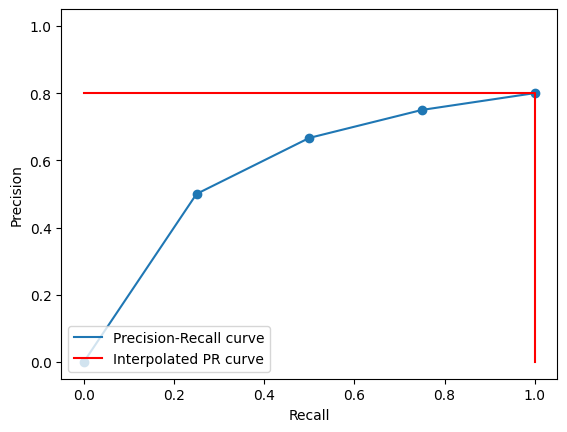

	Query 2


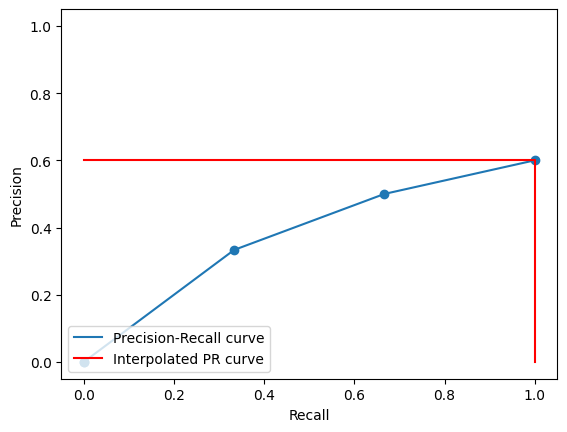

	Query 3


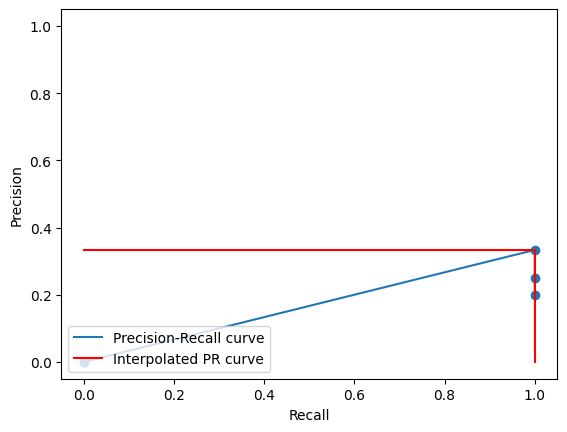

	Query 4


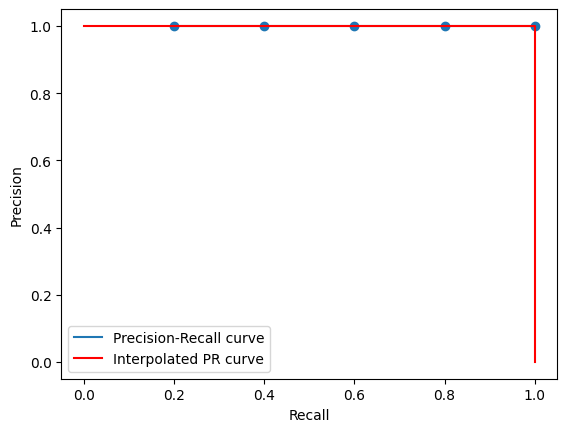

	Query 5


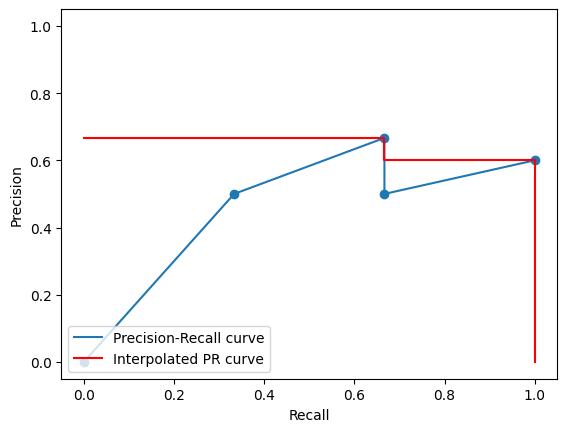

In [21]:
Q = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    Q.append(np.array(retrieved_documents.index))
    
R = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    R.append(np.array([1 if data.loc[article_id, 'Category'] in user_interests[user_id] else -1 for article_id in retrieved_documents.index])
)
    
evaluate('prec_rec', Q, R)

# Doc Embeddings

In [22]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Tokenizar los documentos y crear objetos TaggedDocument
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(data['Text'])]

# Entrenar el modelo Doc2Vec

model = Doc2Vec(window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

user_retrieved_documents: Dict[int, pd.DataFrame] = {
    user_id: pd.DataFrame(
        index=data.index,
        columns=['SimilarityScore']
    )
    for user_id, _ in user_interests.items()
}

document_embeddings = [model.dv[str(i)] for i in range(len(data['Text']))]

# Process user queries
for user_id, interests in user_interests.items():
    # Aggregate word embeddings for the user's interests to generate the query embedding
    interests_simplified = word_simplifier.simplify(interests)
    query_embedding = model.infer_vector(interests_simplified)
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)[0]
    top_documents_indices = similarity_scores.argsort()[::-1]
    for document_index in top_documents_indices:
        article_id = data.index[document_index]
        user_retrieved_documents[user_id].loc[article_id] = similarity_scores[document_index]
        print(f'\tDocument {article_id} with similarity score {similarity_scores[document_index]:.2f}')

	Document 169 with similarity score 0.78
	Document 1899 with similarity score 0.78
	Document 208 with similarity score 0.78
	Document 2084 with similarity score 0.76
	Document 1258 with similarity score 0.76
	Document 517 with similarity score 0.75
	Document 1570 with similarity score 0.75
	Document 1001 with similarity score 0.75
	Document 1554 with similarity score 0.74
	Document 2039 with similarity score 0.74
	Document 792 with similarity score 0.74
	Document 1260 with similarity score 0.73
	Document 2207 with similarity score 0.73
	Document 642 with similarity score 0.73
	Document 1498 with similarity score 0.73
	Document 2176 with similarity score 0.73
	Document 2060 with similarity score 0.73
	Document 330 with similarity score 0.72
	Document 882 with similarity score 0.72
	Document 494 with similarity score 0.72
	Document 471 with similarity score 0.72
	Document 193 with similarity score 0.72
	Document 1792 with similarity score 0.72
	Document 1083 with similarity score 0.72
	D

In [23]:
user_retrieved_documents[2].sort_values(by='SimilarityScore', ascending=False).head(num_documents_to_retrieve)

,SimilarityScore
ArticleId,
503,0.733016
312,0.730802
1937,0.725061
1388,0.72258
636,0.716128


Precision and Recall at k for k=1,...,5
	Query 1
		P(1)=1/1=1.00,	R(1)=1/3=0.33
		P(2)=1/2=0.50,	R(2)=1/3=0.33
		P(3)=2/3=0.67,	R(3)=2/3=0.67
		P(4)=3/4=0.75,	R(4)=3/3=1.00
		P(5)=3/5=0.60,	R(5)=3/3=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/1=0.00
		P(2)=0/2=0.00,	R(2)=0/1=0.00
		P(3)=0/3=0.00,	R(3)=0/1=0.00
		P(4)=1/4=0.25,	R(4)=1/1=1.00
		P(5)=1/5=0.20,	R(5)=1/1=1.00
	Query 3
		P(1)=1/1=1.00,	R(1)=1/3=0.33
		P(2)=2/2=1.00,	R(2)=2/3=0.67
		P(3)=3/3=1.00,	R(3)=3/3=1.00
		P(4)=3/4=0.75,	R(4)=3/3=1.00
		P(5)=3/5=0.60,	R(5)=3/3=1.00
	Query 4
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=1/2=0.50,	R(2)=1/3=0.33
		P(3)=1/3=0.33,	R(3)=1/3=0.33
		P(4)=2/4=0.50,	R(4)=2/3=0.67
		P(5)=3/5=0.60,	R(5)=3/3=1.00
	Query 5
		P(1)=1/1=1.00,	R(1)=1/4=0.25
		P(2)=2/2=1.00,	R(2)=2/4=0.50
		P(3)=2/3=0.67,	R(3)=2/4=0.50
		P(4)=3/4=0.75,	R(4)=3/4=0.75
		P(5)=4/5=0.80,	R(5)=4/4=1.00

 Draw the Precision-Recall curve for each query
	Query 1


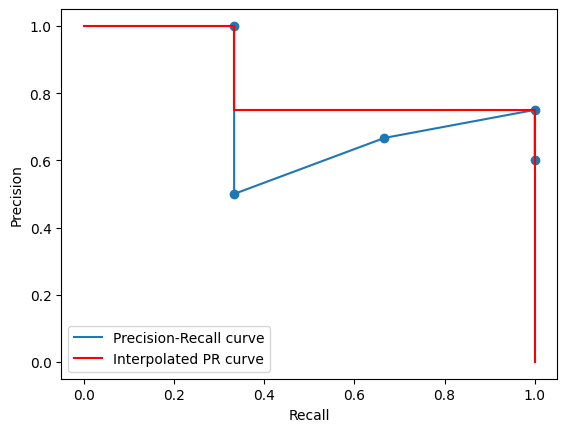

	Query 2


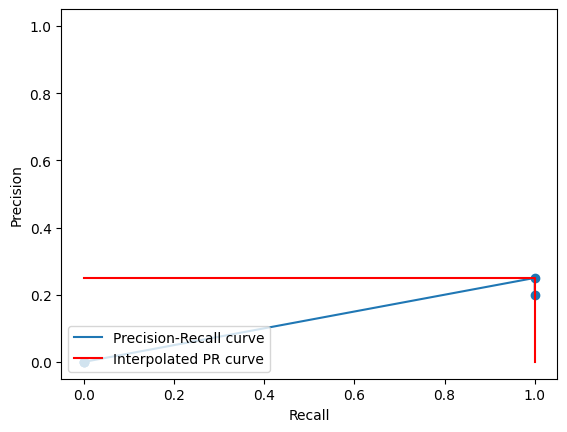

	Query 3


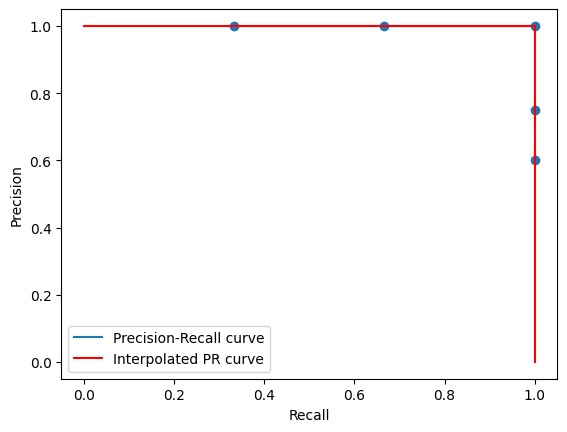

	Query 4


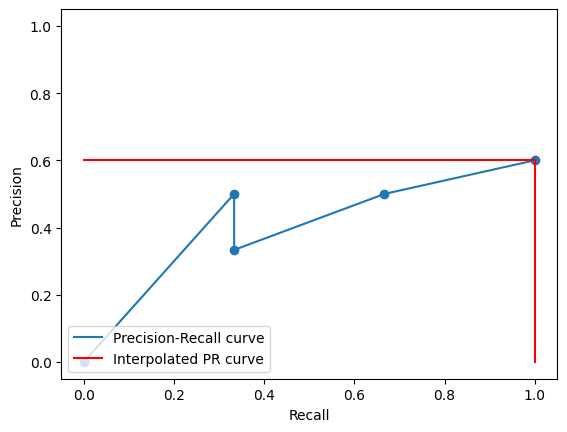

	Query 5


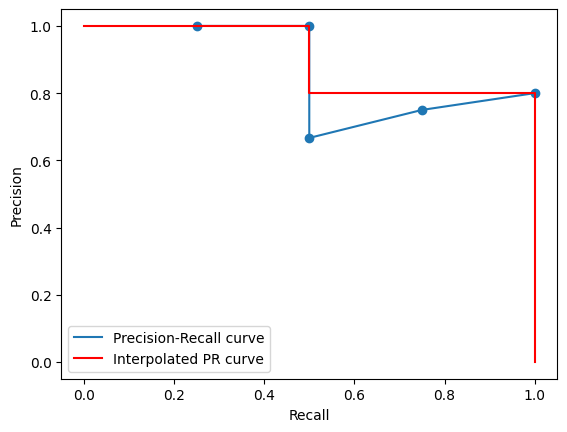

In [24]:
Q = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    Q.append(np.array(retrieved_documents.index))
    
R = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    R.append(np.array([1 if data.loc[article_id, 'Category'] in user_interests[user_id] else -1 for article_id in retrieved_documents.index])
)

evaluate('prec_rec', Q, R)